## This is a tutorial on generating captions for a given image.

In [1]:
import numpy as np
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

import string
import os
import glob
from PIL import Image
from time import time
from collections import Counter

import tensorflow as tf
from keras import layers,Input
from keras import optimizers
from keras.optimizers import adam_v2
from keras.preprocessing import sequence
# from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM,Dense,Flatten,Reshape,Activation,Dropout,Embedding
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
# from keras.utils import to_categorical

In [2]:
dir_flickr8k_jpg = "./flicker8k/Images"
dir_flickr8k_text = './flicker8k/Flickr8k.token.txt'

jpgs=os.listdir(dir_flickr8k_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


In [3]:
file =open(dir_flickr8k_text,'r')
texts = file.read()
file.close()
captionTexts = []
count=0
for line in texts.split('\n'):
#     print(line)
    col = line.split('\t')
    if(len(col)==1):
        continue
    w=col[0].split("#")
    captionTexts.append(w + [col[1].lower()])
    
df_capTxt = pd.DataFrame(captionTexts,columns=['ImageCode','Captionno','Caption'])

uni_filenames = np.unique(df_capTxt.ImageCode.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_capTxt.ImageCode.values).values())

The number of unique file names : 8092
The distribution of the number of captions for each image:


Counter({5: 8092})

## Visualising the data set
## shows 5 images along with their captions

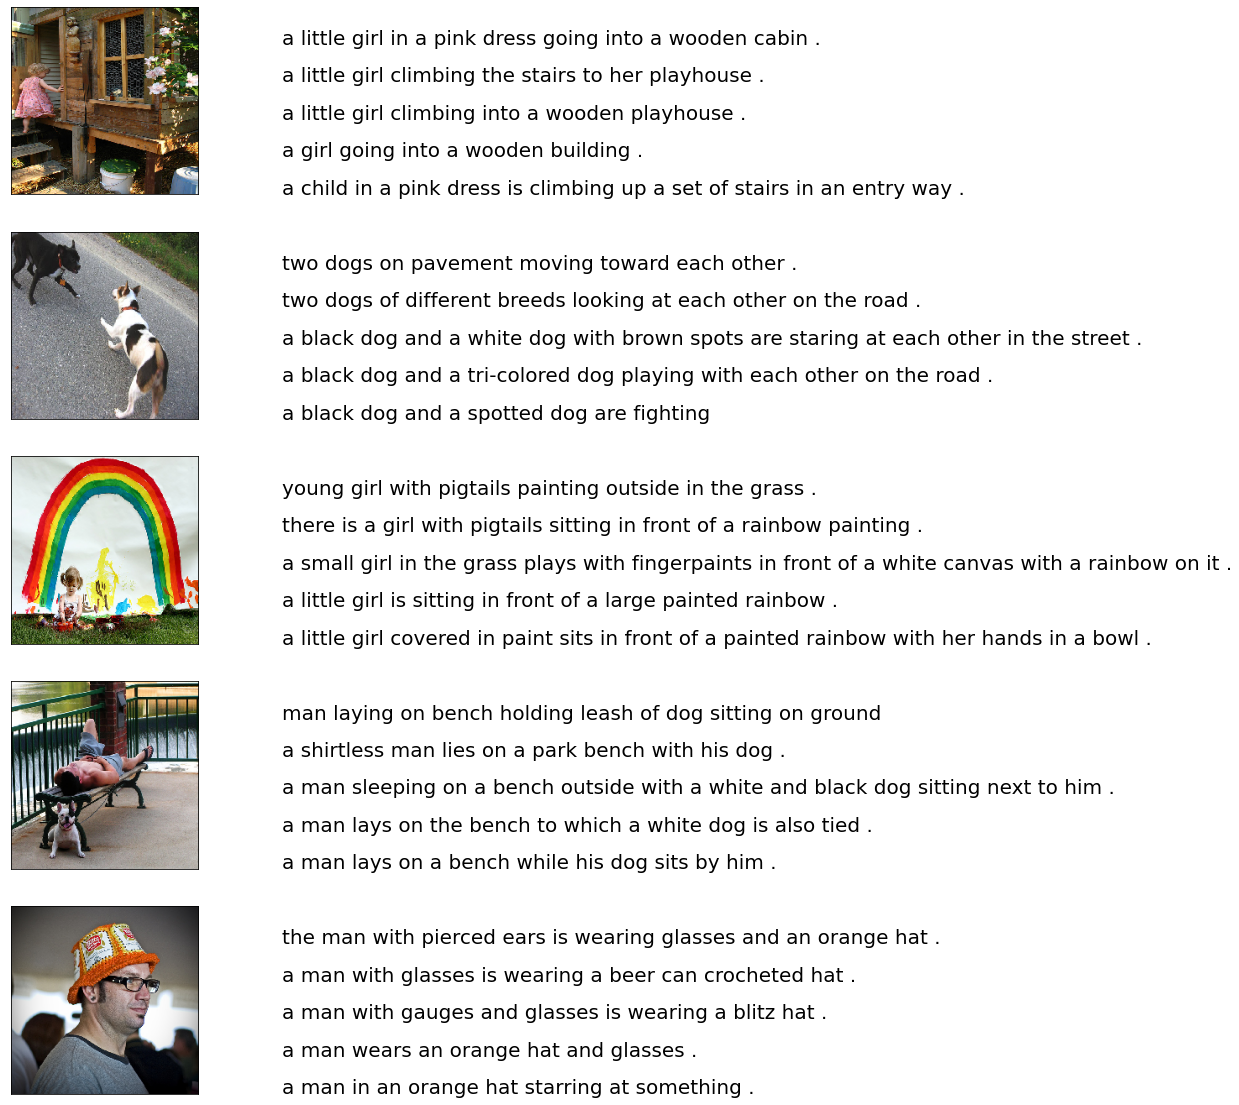

In [4]:
from keras.preprocessing.image import load_img,img_to_array

no_of_captions = 5
img_size = 224
target_size=(img_size,img_size,3)

count = 1
fig = plt.figure(figsize=(10,20))
#printing first 5 images along with their captions
for jpgfnm in uni_filenames[:no_of_captions]:
    imageCode = dir_flickr8k_jpg +'/'+ jpgfnm
    captions = list(df_capTxt["Caption"].loc[df_capTxt["ImageCode"]==jpgfnm].values)
    image = load_img(imageCode,target_size=target_size)
    ax = fig.add_subplot(no_of_captions,2,count,xticks=[],yticks=[])
    ax.imshow(image)
    count += 1
    
    ax = fig.add_subplot(no_of_captions,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [5]:
df_capTxt.head(100)

,ImageCode,Captionno,Caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...
...,...,...,...
95,102351840_323e3de834.jpg,0,a man drilling a hole in the ice .
96,102351840_323e3de834.jpg,1,a man is drilling through the frozen ice of a ...
97,102351840_323e3de834.jpg,2,a person in the snow drilling a hole in the ice .
98,102351840_323e3de834.jpg,3,a person standing on a frozen lake .


# Text Preprocessing

In [6]:
token_path = "./flicker8k/Flickr8k.token.txt"
train_images_path = './flicker8k/Flickr_8k.trainImages.txt'
test_images_path = './flicker8k/Flickr_8k.testImages.txt'
images_path = './flicker8k/Flicker8k_Dataset/'
glove_path = '../glove6b'

In [7]:
lines = list()
for imageCode in uni_filenames:
    img_code = imageCode.split('.')[0]
    captions=list(df_capTxt["Caption"].loc[df_capTxt["ImageCode"]==imageCode].values)
    for caption in captions:
        lines.append(img_code +" "+ caption)
new_descriptions = '\n'.join(lines)

# Getting all the images and keeping it as train set

In [8]:
file = open(train_images_path,'r').read()
dataset = list()
for line in file.split('\n'):
    if len(line) > 1:
        imageno = line.split('.')[0]
        dataset.append(imageno)

train = set(dataset)

## getting the images for the training and testing set respectively

In [9]:
img = glob.glob(images_path+ '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)


## Loading the descriptions of each image in decriptions dict.
## Adding start and end token in every description or caption

In [10]:
train_captions = dict()
for line in new_descriptions.split('\n'):
    token = line.split()
    image_id,image_cap = token[0],token[1:]
    if image_id in train:
        if image_id not in train_captions:
            train_captions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_cap) + ' endseq'
        train_captions[image_id].append(desc)

## Creating training captions of all training images

In [11]:
all_training_captions = []
for key,val in train_captions.items():
    for cap in val:
        all_training_captions.append(cap)

## To make our model more robust we will reduce our vocabulary to only those words which occur at least 10 times in the entire corpus.

In [12]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_training_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1664


## Now we create two dictionaries to map words to an index and vice versa. Also, we append 1 to our vocabulary since we append 0’s to make all captions of equal length.

In [13]:
index_to_word ={}
word_to_index ={}
index=1
for word in vocab:
    word_to_index[word]=index
    index_to_word[index] =word
    index+=1

vocab_size = len(index_to_word)+1

## We also need to find out what the max length of a caption can be since we cannot have captions of arbitrary length.

In [14]:
all_desc = list()
for image_id in train_captions.keys():
#     print(image_id)
    [all_desc.append(d) for d in train_captions[image_id]]

lines = all_desc
max_length = max(len(word.split()) for word in all_desc)

print("max-length for word description will be",max_length)

max-length for word description will be 40


# GloVe Embeedings

## Word vectors map words to a vector space, where similar words are clustered together and different words are separated. The advantage of using Glove over Word2Vec is that GloVe does not just rely on the local context of words but it incorporates global word co-occurrence to obtain word vectors.

## The basic premise behind Glove is that we can derive semantic relationships between words from the co-occurrence matrix. For our model, we will map all the words in our 38-word long caption to a 200-dimension vector using Glove.

In [15]:
embeddings_index={}
# f = open(os.path.join(glove_path,'glove.6d.200d.txt'),encoding='utf-8')
f = open('../glove6b/glove.6B.200d.txt',encoding='utf-8')
for line in f:
#     print(line)
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word] = coefs

In [16]:
embeddings_index['nice']

array([ 0.78194  , -0.29161  , -0.33442  , -0.045787 ,  0.19279  ,
       -0.96119  , -0.47081  , -0.60557  ,  0.55217  ,  0.11001  ,
       -0.69748  ,  0.33068  ,  0.62055  ,  0.044207 ,  0.23349  ,
        0.24149  , -0.30086  ,  0.27041  ,  0.13014  , -0.36415  ,
        0.46842  ,  1.3725   ,  0.25747  , -0.22742  ,  0.32778  ,
       -0.93674  , -0.2354   , -0.14481  , -0.30463  , -0.53756  ,
       -0.1033   , -0.14534  , -0.099943 ,  0.27461  ,  0.17375  ,
       -0.35866  , -0.2742   , -0.26783  ,  0.0040517, -0.021352 ,
       -0.10351  ,  0.19965  , -0.15085  ,  0.32754  , -0.13745  ,
        0.25835  ,  0.83756  ,  0.56503  , -0.106    ,  0.52289  ,
       -0.21384  ,  0.21656  ,  0.080733 ,  1.0957   , -0.1415   ,
       -0.00903  ,  0.13832  , -0.19462  ,  0.48089  , -0.72768  ,
        0.46295  , -0.29824  , -0.33902  ,  0.22312  , -0.13328  ,
        0.34703  , -0.22908  , -0.057086 ,  0.66757  ,  0.15203  ,
        0.04544  ,  0.3117   , -0.16322  , -0.41499  , -0.4022

## Next, we make the matrix of shape (1665,200) consisting of our vocabulary and the 200-d vector.
## So for each word in our vocablary we take the vector of the word from the pre-trained glove values

## Since our vocablary size is 1665 we will get 1665 rows and 200 colomns denoting the word vector 

In [17]:
embeddings_dims =200
embeddings_matrix=np.zeros((vocab_size,embeddings_dims))
for word, i in word_to_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

# Model Building and Training

## We have opted for transfer learning using InceptionV3 network which is pre-trained on the ImageNet dataset.

In [18]:
model = InceptionV3(weights='imagenet')

96124928/96112376 [==============================] - 82s 1us/step


## We must remember that we do not need to classify the images here, we only need to extract an image vector for our images. Hence we remove the softmax layer from the inceptionV3 model.

In [19]:
model_new = Model(model.input,model.layers[-2].output)

## Since we are using InceptionV3 we need to pre-process our input before feeding it into the model. Hence we define a preprocess function to reshape the images to (299 x 299) and feed to the preprocess_input() function of Keras.

In [20]:
def preprocess(image_path):
    img =load_img(image_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

## Now we can go ahead and encode our training and testing images, i.e extract the images vectors of shape (2048,)

In [21]:
def encode(img):
    img=preprocess(img)
    img_fea_vec = model_new.predict(img)
    img_fea_vec = np.reshape(img_fea_vec,img_fea_vec.shape[1])
    return img_fea_vec


In [22]:
len(test_img)

1000

In [23]:
encoding_train_img = {}
for img in train_img:
    encoding_train_img[img[len(images_path):]]=encode(img)
train_features = encoding_train_img

In [24]:
encoding_test_img = {}
for img in test_img:
    encoding_test_img[img[len(images_path):]]=encode(img)

## We are creating a Merge model where we combine the image vector and the partial caption. Therefore our model will have 3 major steps:

### Processing the sequence from the text 
### Extracting the feature vector from the image
### Decoding the output using softmax by concatenating the above two layers

In [25]:
inputs1 = Input(shape = (2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256,activation = 'relu')(fe1)

inputs2 = Input(shape = (max_length,))
se1 = Embedding(vocab_size,embeddings_dims,mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2,se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1,inputs2],outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 200)      333000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

# Model Training

## Before training the model we need to keep in mind that we do not want to retrain the weights in our embedding layer (pre-trained Glove vectors).

In [26]:
model.layers[2].set_weights([embeddings_matrix])
model.layers[2].trainable=False

In [27]:
model.compile(loss='categorical_crossentropy',optimizer = 'adam')

In [28]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [29]:
epochs = 5
batch_size = 3
steps = len(train_captions)//batch_size

generator = data_generator(train_captions, train_features, word_to_index, max_length, batch_size)
model.fit(generator,epochs = epochs ,steps_per_epoch=steps,verbose=1)


Epoch 1/5
2000/2000 [==============================] - 737s 366ms/step - loss: 3.4719
Epoch 2/5
2000/2000 [==============================] - 786s 393ms/step - loss: 2.8493
Epoch 3/5
2000/2000 [==============================] - 866s 433ms/step - loss: 2.6629
Epoch 4/5
2000/2000 [==============================] - 794s 397ms/step - loss: 2.5518
Epoch 5/5
2000/2000 [==============================] - 794s 397ms/step - loss: 2.4727


In [31]:
# pickle.dump(model,open("model.pkl","wb"))
pickle.dump(word_to_index,open("wordToIndex.pkl","wb"))
pickle.dump(index_to_word,open("indexToWord.pkl","wb"))


In [32]:
model.save("caption_generator.h5")

C:\Users\atul kumar singh\AppData\Roaming\Python\Python38\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [33]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [34]:
def beam_search_predictions(image, beam_index = 3):
    start = [word_to_index["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [index_to_word[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

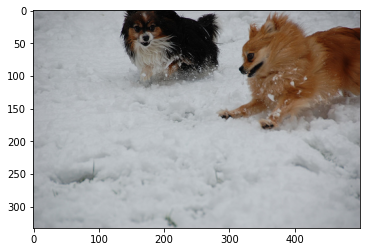

Greedy Search: a dog is running through the snow .
Beam Search, K = 3: a white dog runs through the snow .
Beam Search, K = 5: a brown and white dog is running through the snow .
Beam Search, K = 7: a brown and white dog is running through the snow .
Beam Search, K = 10: a brown and white dog is running through the snow .


In [35]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test_img[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

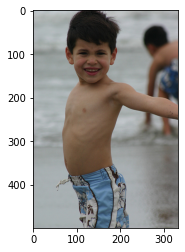

Greedy: a boy in a bathing suit is jumping into the water .
Beam Search, K = 3: a young boy in a bathing suit jumps into the water .
Beam Search, K = 5: a young boy in a bathing suit jumps into the water .
Beam Search, K = 7: a young boy jumping into a swimming pool .


In [36]:
pic = list(encoding_test_img.keys())[1]
image = encoding_test_img[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))